## Week 5 Assignment - Midterm
### Race as Vulnerability: The Relationship between Policing and Gentrification
#### John Parks, Joshua Claxton and Miles Cressy

The aim for this midterm is to demonstrate our progress in assessing the relationship between policing and gentrification. We will do so by first exploring various metrics that help contribute to or inform the process of gentrification, which is broadly defined as the "process whereby the character of a poor urban area is changed by wealthier people moving in, improving housing, and attracting new businesses, typically displacing current inhabitants in the process". In order to accomplish this, we will delve into demographic shifts of renter-occupied households, development patterns through filing of building permits, and rent price changes and rent burden percentages by race. These metrics may change as we progress toward our final project but we hope the evaluation of these metrics get us closer to laying the foundation of our understanding of gentrification.

Following the groundwork we lay for evaluating gentrification, we will dive into various forms of policing data and evalaute the relationship between policing and communities that are susceptible to gentrifying forces.  

__________________________________________________________________________________________________________________________________________________________________________________________________

Import various packages for data manipulation/cleaning and visualization.

In [68]:
# standard data manipulation
import pandas as pd

# geospatial data manipulation/visualization
import geopandas as gpd
import plotly.express as px
import plotly.graph_objects as go

# advanced graph visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator

# To ignore warnings
import warnings
warnings.filterwarnings('ignore')

### Assessing Gentrification

#### Demographic Shifts in Renter-occupied Households

Our first step is to bring in race data from 2017 and 2021, conducting some pre-cleaning as we bring them into the notebook. These values are defined by census tracts for the entirety of LA County but we want to analyze this data within the context of neighbhorhoods within the boundary of LA city - to do this, we will bring in a LA neighborhood geojson as well.

In [72]:
# import demographic csv file data from 2017 Census, rename FIPS column for merge and add a leading zero.
tracts_race_17 = pd.read_csv('data/race_2017.csv', dtype = {'fips':str})
tracts_race_17.rename(columns={'fips': 'FIPS'}, inplace=True)
tracts_race_17['FIPS'] = tracts_race_17['FIPS'].str.zfill(11)

# import demographic csv file data from 2021 Census, rename some columns for merge and add a leading zero.
tracts_race_21 = pd.read_csv('data/rent_burden_ct_1.csv',dtype = {'Geo_FIPS':str})
tracts_race_21.rename(columns={'total_housing_units': 'total','white_alone':'white','black_alone':'black','asian_alone':'asian' }, inplace=True)
tracts_race_21['FIPS'] = tracts_race_21['Geo_FIPS'].str.zfill(11)

# import LA neighborhoods from ArcGIS
nbh = gpd.read_file("https://services5.arcgis.com/7nsPwEMP38bSkCjy/arcgis/rest/services/LA_Times_Neighborhoods/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson")

In [73]:
#check 2017 dataframe
tracts_race_17.head()

,FIPS,total,white,black,american_indian,asian,hawaiian,other,two_or_more,white_not_hispanic,hispanic
0,06037101110,816,587,26,0,19,0,155,29,483,282
1,06037101122,230,211,0,0,19,0,0,0,177,34
2,06037101210,1975,1551,69,0,61,0,272,22,987,836
3,06037101220,808,532,11,0,112,0,90,63,428,177
4,06037101300,171,112,0,0,25,0,26,8,112,34


In [74]:
#check 2021 dataframe
tracts_race_21.head()

,Geo_FIPS,total,white,black,american_indian_alone,asian,native_hawaiian_alone,other,two_or_more,white_alone_not_hisp,hispanic,total_pop,rent_burden,FIPS
0,6037101110,644,438,0,0,58,0,52,96,372,207,3879,0.549689,06037101110
1,6037101122,344,287,0,0,0,0,33,24,287,33,4247,0.706395,06037101122
2,6037101220,762,450,8,16,48,0,110,130,394,285,3583,0.535433,06037101220
3,6037101221,1140,815,68,0,25,0,178,54,747,269,3723,0.663158,06037101221
4,6037101222,816,715,17,0,28,17,28,11,515,239,2690,0.651961,06037101222


We will subset our race dataframes to only contain the major racial groups as this will simplify our analysis but keep our results and conclusions nearly the same.

In [75]:
#subset dataframes and conduct additional review
tracts_race_17 = tracts_race_17[['FIPS','total','white','black','asian','hispanic']]
tracts_race_21 = tracts_race_21[['FIPS','total','white','black','asian','hispanic']]

In [76]:
#review subsetted dataframe
tracts_race_17.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2346 entries, 0 to 2345
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   FIPS      2346 non-null   object
 1   total     2346 non-null   int64 
 2   white     2346 non-null   int64 
 3   black     2346 non-null   int64 
 4   asian     2346 non-null   int64 
 5   hispanic  2346 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 110.1+ KB


In [77]:
#review subsetted dataframe
tracts_race_21.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2498 entries, 0 to 2497
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   FIPS      2498 non-null   object
 1   total     2498 non-null   int64 
 2   white     2498 non-null   int64 
 3   black     2498 non-null   int64 
 4   asian     2498 non-null   int64 
 5   hispanic  2498 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 117.2+ KB


It is important to note that the Census was conducted in 2020, meaning the census tract boundaries are either different or have completely changed in some cases. We wanted to ensure that we had a good historical coverage to view demographic shifts through but we are doing so at the cost of lost observations due to dissimilar census tracts.

In [78]:
#merge census tract dataframes from both years on FIPS, then review data
race_merge = tracts_race_17.merge(tracts_race_21, on='FIPS',
                                  suffixes=('_2017', '_2021'),
                                 indicator=True)
race_merge.describe()

,total_2017,white_2017,black_2017,asian_2017,hispanic_2017,total_2021,white_2021,black_2021,asian_2021,hispanic_2021
count,2022.000000,2022.000000,2022.000000,2022.000000,2022.000000,2022.000000,2022.000000,2022.000000,2022.000000,2022.000000
mean,727.787339,371.790307,85.225519,91.897626,322.763600,732.410979,327.737389,83.417903,91.102374,329.230465
std,478.751748,337.873194,143.152049,139.897347,258.725869,493.469446,324.412235,139.688290,137.745780,259.052992
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,364.000000,147.000000,0.000000,7.000000,105.000000,356.500000,119.000000,0.000000,7.000000,114.000000
50%,662.000000,275.500000,32.000000,41.000000,267.000000,660.500000,230.000000,33.000000,41.000000,274.000000
75%,991.500000,497.000000,101.750000,115.000000,498.000000,1009.000000,421.000000,104.000000,117.750000,509.750000
max,3879.000000,3217.000000,1587.000000,1257.000000,1209.000000,3895.000000,2868.000000,1218.000000,1442.000000,1326.000000


**Observations:**
- a
- b
- c

After merging to ensure that all similar census tracts were accounted for, we will separate the dataframe by year, add a year column and then append them together in order to create a longer (rather than a wider) dataframe.

In [79]:
# now disaggregatge to make the dataset long instead of wide to prepare for appending
ct_21 = race_merge[['FIPS','total_2021','white_2021','black_2021', 'asian_2021', 'hispanic_2021']]
ct_21.rename(columns={'total_2021': 'total','white_2021':'white','black_2021':
                               'black','asian_2021':'asian','hispanic_2021':'hispanic' }, inplace=True)
ct_17 = race_merge.drop(columns=['_merge','total_2021','white_2021','black_2021', 'asian_2021', 'hispanic_2021'])
ct_17.rename(columns={'total_2017': 'total','white_2017':'white','black_2017':
                               'black','asian_2017':'asian','hispanic_2017':'hispanic' }, inplace=True)

In [80]:
# add column for year for each demographic dataset
ct_17['year']=2017
ct_21['year']=2021
# demogaphic information is ready to be appended
ct_race=ct_17.append(ct_21)
# 10 year census tract data for understanding of demograhic shifts, with each shared census tract having two observations (one for 2017 and one for 2021)
ct_race.sort_values(by=['year','FIPS'])
ct_race

,FIPS,total,white,black,asian,hispanic,year
0,06037101110,816,587,26,19,282,2017
1,06037101122,230,211,0,19,34,2017
2,06037101220,808,532,11,112,177,2017
3,06037101300,171,112,0,25,34,2017
4,06037101400,460,364,0,35,216,2017
...,...,...,...,...,...,...,...
2017,06037980031,10,10,0,0,10,2021
2018,06037980033,13,0,0,0,0,2021
2019,06037990100,0,0,0,0,0,2021
2020,06037990200,0,0,0,0,0,2021


Having organized our data appropriately, we will now add in geospatial information so that we can later spatially join the census tracts into the LA neighborhood geodataframe. This will entail bringing in census tract data, adjusting the columns to match our working dataframe and then a merge to join the data together.

In [81]:
# merge in census spatial information
tracts=gpd.read_file('data/Census_Tracts_2020.geojson')
# subset for only relevant information
tracts = tracts[['CT20','geometry']]
# create new column using CT20 column that allows us to merge on FIPS
tracts['FIPS'] ='06' + '037' + tracts['CT20']
# merge now that we have a shared column
spatial_race=tracts.merge(ct_race, on='FIPS')
# double check this worked correctly
spatial_race.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 4038 entries, 0 to 4037
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   CT20      4038 non-null   object  
 1   geometry  4038 non-null   geometry
 2   FIPS      4038 non-null   object  
 3   total     4038 non-null   int64   
 4   white     4038 non-null   int64   
 5   black     4038 non-null   int64   
 6   asian     4038 non-null   int64   
 7   hispanic  4038 non-null   int64   
 8   year      4038 non-null   int64   
dtypes: geometry(1), int64(6), object(2)
memory usage: 315.5+ KB


In [82]:
# explore neighborhoods
nbh.head()

,OBJECTID,name,geometry
0,1,Adams-Normandie,"POLYGON ((-118.30069 34.03731, -118.30388 34.0..."
1,2,Arleta,"POLYGON ((-118.44255 34.26412, -118.44240 34.2..."
2,3,Arlington Heights,"POLYGON ((-118.31862 34.05306, -118.31673 34.0..."
3,4,Atwater Village,"MULTIPOLYGON (((-118.27886 34.15321, -118.2788..."
4,5,Baldwin Hills/Crenshaw,"POLYGON ((-118.36102 34.02532, -118.36026 34.0..."


In [83]:
# check coordinate system to ensure they match on join
nbh.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [84]:
# prepare demographic data for spatial join with neighborhoods
# first adjust census data to point data 
spatial_race = spatial_race.to_crs(4326)
spatial_race['Centroid']=spatial_race.to_crs('+proj=cea').centroid.to_crs(spatial_race.crs)
spatial_race_1 = spatial_race.to_crs(4326)
spatial_race_1 = spatial_race_1.drop(columns=['CT20','geometry'])
spatial_race_1.rename(columns={'Centroid': 'geometry'}, inplace=True)
spatial_race_1.head(20)

,FIPS,total,white,black,asian,hispanic,year,geometry
0,06037101110,816,587,26,19,282,2017,POINT (-118.29300 34.25948)
1,06037101110,644,438,0,58,207,2021,POINT (-118.29300 34.25948)
2,06037101122,230,211,0,19,34,2017,POINT (-118.29016 34.26773)
3,06037101122,344,287,0,0,33,2021,POINT (-118.29016 34.26773)
4,06037101220,808,532,11,112,177,2017,POINT (-118.28164 34.25161)
5,06037101220,762,450,8,48,285,2021,POINT (-118.28164 34.25161)
6,06037101300,171,112,0,25,34,2017,POINT (-118.27101 34.24878)
7,06037101300,242,170,0,0,52,2021,POINT (-118.27101 34.24878)
8,06037101400,460,364,0,35,216,2017,POINT (-118.29417 34.24286)
9,06037101400,387,353,0,34,68,2021,POINT (-118.29417 34.24286)


Now that the race data is cleaned and prepped, we will run a spatial join on the race data (now with census tract centroids) and the neighborhood polygon data.

In [85]:
# spatial join
nbh_race = nbh.sjoin(spatial_race_1, how="left")
nbh_race.sort_values(by=['FIPS','year'])
nbh_race.head()

,OBJECTID,name,geometry,index_right,FIPS,total,white,black,asian,hispanic,year
0,1,Adams-Normandie,"POLYGON ((-118.30069 34.03731, -118.30388 34.0...",1225,06037221601,796,222,152,26,585,2021
0,1,Adams-Normandie,"POLYGON ((-118.30069 34.03731, -118.30388 34.0...",1222,06037221500,1031,161,453,34,513,2017
0,1,Adams-Normandie,"POLYGON ((-118.30069 34.03731, -118.30388 34.0...",1223,06037221500,850,215,283,68,416,2021
0,1,Adams-Normandie,"POLYGON ((-118.30069 34.03731, -118.30388 34.0...",1241,06037222100,795,216,196,32,495,2021
0,1,Adams-Normandie,"POLYGON ((-118.30069 34.03731, -118.30388 34.0...",1240,06037222100,782,111,281,79,379,2017


Now that we've successfully joined the dataframes, let's organize our new geodataframe, create new columns based on the metric we're interested in analyzing and then sort by those new columns.

In [116]:
# collapse by year and neighborhood
nbhr = nbh_race.groupby(['year','name'],
                                           as_index=False).agg(Geometry = ('geometry','first'),
                                                               Total = ('total','sum'),
                                                               White = ('white','sum'),
                                                               Black = ('black','sum'),
                                                               Asian = ('asian','sum'),
                                                               Hispanic = ('hispanic','sum')
                                                              )
nbhr = nbhr.sort_values(by=['name','year'])
nbhr.head(20)

,year,name,Geometry,Total,White,Black,Asian,Hispanic
0,2017,Adams-Normandie,"POLYGON ((-118.30069 34.03731, -118.30388 34.0...",4187,713,1332,402,2151
114,2021,Adams-Normandie,"POLYGON ((-118.30069 34.03731, -118.30388 34.0...",4246,1132,930,472,2460
1,2017,Arleta,"POLYGON ((-118.44255 34.26412, -118.44240 34.2...",848,487,11,72,696
115,2021,Arleta,"POLYGON ((-118.44255 34.26412, -118.44240 34.2...",723,368,0,38,626
2,2017,Arlington Heights,"POLYGON ((-118.31862 34.05306, -118.31673 34.0...",5181,1217,983,994,2858
116,2021,Arlington Heights,"POLYGON ((-118.31862 34.05306, -118.31673 34.0...",5179,1232,1203,831,2596
3,2017,Atwater Village,"MULTIPOLYGON (((-118.27886 34.15321, -118.2788...",2565,1466,18,438,855
117,2021,Atwater Village,"MULTIPOLYGON (((-118.27886 34.15321, -118.2788...",2803,1466,8,565,862
4,2017,Baldwin Hills/Crenshaw,"POLYGON ((-118.36102 34.02532, -118.36026 34.0...",4428,710,3194,153,796
118,2021,Baldwin Hills/Crenshaw,"POLYGON ((-118.36102 34.02532, -118.36026 34.0...",4388,530,2908,192,1070


Now that our geodataframe is organized appropriately, we will generate new columns based on white and black demographic shifts. Before doing so, considering we no longer have use for our 2017 data, we will drop those rows along with any 2021 rows that have missing data. We will then generate a new column that evaluates the differential between the black and white renter population shift as a way to measure the neighborhoods experiencing the greatest change - we will sort our dataframe by this value and produce a bar chart that visualizes this.

In [117]:
# row calculations to determine % shifts in renter-occupied household demographics
nbhr['delta_b'] = nbhr['Black'].div(nbhr.groupby('name')['Black'].shift())
nbhr['delta_b_perc'] = nbhr['delta_b']*100
nbhr['delta_w'] = nbhr['White'].div(nbhr.groupby('name')['White'].shift())
nbhr['delta_w_perc'] = nbhr['delta_w']*100
nbhr['difference'] = nbhr.delta_w_perc - nbhr.delta_b_perc
nbhr = nbhr.sort_values('difference', ascending = False)

# drop 2017 and 2021 null values
nbhr_trim = nbhr[nbhr['delta_b'].notna()]

# select for the black communities that are populous and where black folks have moved or been moved out in the past decade
nbhr_trim_black = nbhr_trim[(nbhr_trim['Black']>500) & (nbhr_trim['delta_b_perc']<100)]
nbhr_trim_black.head(20)

,year,name,Geometry,Total,White,Black,Asian,Hispanic,delta_b,delta_b_perc,delta_w,delta_w_perc,difference
114,2021,Adams-Normandie,"POLYGON ((-118.30069 34.03731, -118.30388 34.0...",4246,1132,930,472,2460,0.698198,69.819820,1.587658,158.765778,88.945959
165,2021,Jefferson Park,"POLYGON ((-118.31335 34.03721, -118.30900 34.0...",6268,1416,2517,333,2680,0.856122,85.612245,1.573333,157.333333,71.721088
145,2021,Exposition Park,"POLYGON ((-118.29155 34.01837, -118.28294 34.0...",6115,1419,1753,446,3293,0.880020,88.002008,1.376334,137.633366,49.631358
221,2021,Westchester,"POLYGON ((-118.35862 33.98240, -118.35856 33.9...",3906,1953,588,586,922,0.733167,73.316708,1.153574,115.357354,42.040646
125,2021,Broadway-Manchester,"POLYGON ((-118.26954 33.92919, -118.26956 33.9...",4211,975,1555,41,2541,0.730047,73.004695,1.090604,109.060403,36.055708
214,2021,Vermont Square,"POLYGON ((-118.28112 34.01109, -118.28121 34.0...",5710,1769,1624,124,3820,0.874529,87.452881,1.227620,122.761971,35.309090
215,2021,Vermont Vista,"POLYGON ((-118.28044 33.92912, -118.28066 33.9...",3606,915,1456,34,2089,0.917454,91.745432,1.194517,119.451697,27.706265
200,2021,South Park,"POLYGON ((-118.28040 33.98916, -118.28061 33.9...",5655,1648,807,64,4675,0.771511,77.151052,1.036478,103.647799,26.496747
151,2021,Green Meadows,"POLYGON ((-118.25411 33.95104, -118.25411 33.9...",4960,1277,1794,0,3149,0.887679,88.767937,1.108507,110.850694,22.082758
174,2021,Mar Vista,"POLYGON ((-118.42142 34.01033, -118.42010 34.0...",9749,5869,597,1535,2445,0.826870,82.686981,1.023009,102.300854,19.613873


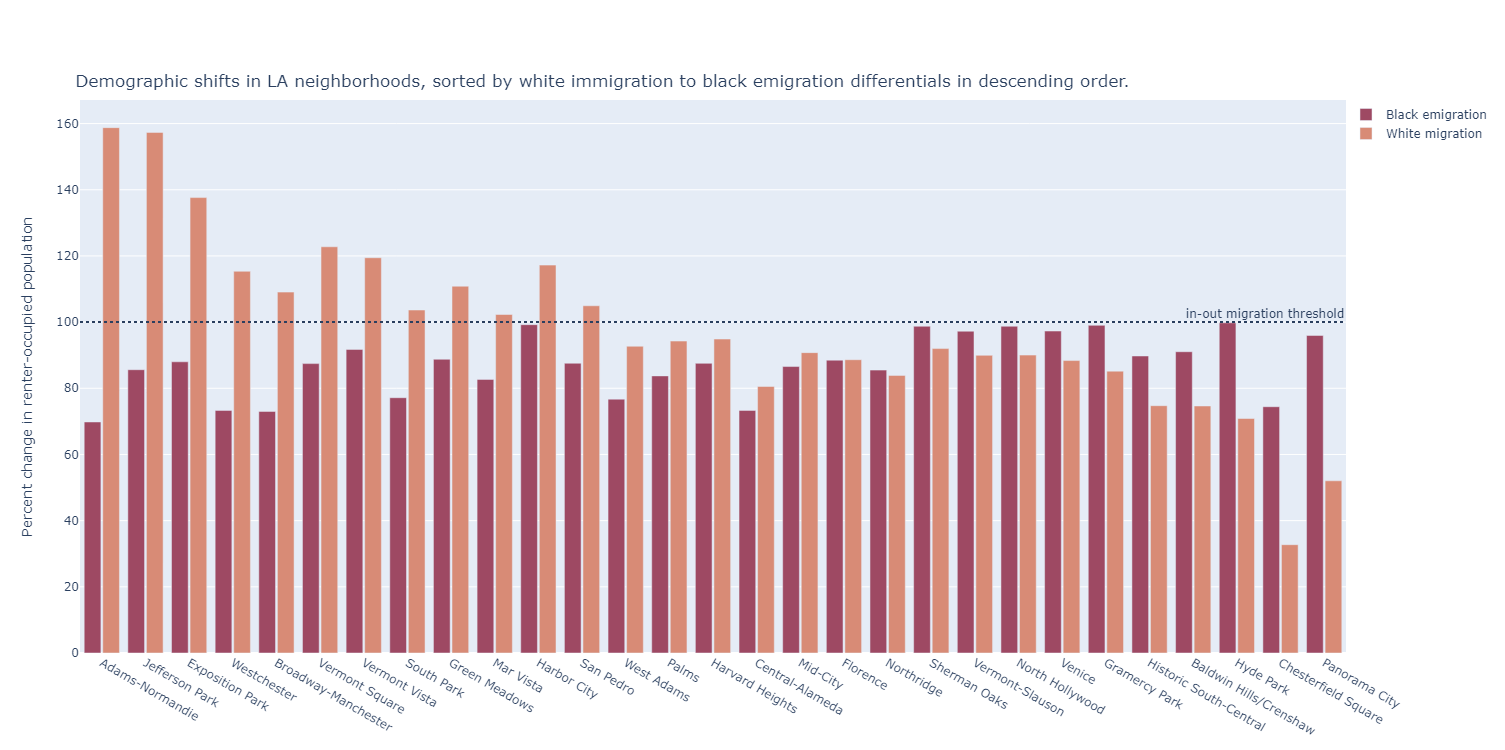

In [129]:
# let's plot our findings from above
fig = go.Figure()

# set visual style
sns.set(style="darkgrid")

fig.add_trace(go.Bar(x=nbhr_trim_black['name'],
                y=nbhr_trim_black['delta_b_perc'],
                name='Black emigration',
                marker_color='rgb(158,73,99)'
                ))
fig.add_trace(go.Bar(x=nbhr_trim_black['name'],
                     y=nbhr_trim_black['delta_w_perc'],
                     name='White migration',
                marker_color='rgb(216,139,118)'
                ))
fig.add_hline(y=100, line_dash="dot",
              annotation_text="in-out migration threshold", 
              annotation_position="top right")

fig.update_layout(
    title='Demographic shifts in LA neighborhoods, sorted by white immigration to black emigration differentials in descending order.',
    title_y = .9,
    xaxis_tickfont_size=12,
    yaxis=dict(
        title='Percent change in renter-occupied population',
        titlefont_size=14,
        tickfont_size=12,
    ),
    legend=dict(
        x=1,
        y=1.0,
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    barmode='group',
    bargap=0.15, # gap between bars of adjacent location coordinates.
    bargroupgap=0.1 ,# gap between bars of the same location coordinate.
    
    width=1500,
    height=750
)
fig.show()

Remarks:
- a


________________________________________________________________________________________________________________________________________________________________________________________________________________

#### Development: Builing Permits

Now that we've assessed demographic shifts, let's begin layering/combining other metrics that help to inform a definition of gentrification. Let's take a look at building permits from LA City Data in order to assess the degree to which a neighborhood is undergoing development.

In [150]:
# load in csv
df_permit = pd.read_csv('data/Building_Permits_clean')
# we don't need this column right now - we'll drop for the time being
df_permit = df_permit.drop(columns = '# of Residential Dwelling Units')
df_permit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1584195 entries, 0 to 1584194
Data columns (total 4 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   Census Tract        1582874 non-null  float64
 1   Permit Sub-Type     1584195 non-null  object 
 2   Issue Date          1584195 non-null  object 
 3   Latitude/Longitude  1499419 non-null  object 
dtypes: float64(1), object(3)
memory usage: 48.3+ MB


In [151]:
# check size of dataframe
df_permit.shape

(1584195, 4)

This is a very large file, we will need to subset in order to manage it size. Let's start by removing null values so we can trim it down.

In [152]:
# view # of missing values
print(df_permit['Latitude/Longitude'].isna().sum())
print(df_permit['Census Tract'].isna().sum())

84776
1321


In [153]:
# drop missing values and re-check to see if we successfully dropped
df_permit = df_permit[df_permit['Latitude/Longitude'].isna() != True]
df_permit = df_permit[df_permit['Census Tract'].isna() != True]
print(df_permit['Latitude/Longitude'].isna().sum())
print(df_permit['Census Tract'].isna().sum())

0
0


In [154]:
# we need to parse out the lat/long values into a format that geopandas can join on, we'll split the column 'Latitude/Longitude' into 'lat' and 'long' and convert to numeric
# split column, then adding new columns with split results
df_permit[['lat', 'long']] = df_permit['Latitude/Longitude'].str.split(', ', expand=True)
# remove unnessary characters
df_permit["lat"]=df_permit["lat"].str.replace('(','')
df_permit["long"]=df_permit["long"].str.replace(')','')
# convert string to numeric
df_permit['lat'] = pd.to_numeric(df_permit['lat'])
df_permit['long'] = pd.to_numeric(df_permit['long'])
# drop unused column
df_permit = df_permit.drop(columns = ['Latitude/Longitude'])
df_permit.head()

,Census Tract,Permit Sub-Type,Issue Date,lat,long
0,2364.00,1 or 2 Family Dwelling,10/06/2021,34.00870,-118.35113
1,1920.02,Apartment,10/01/2021,34.08411,-118.35721
2,1347.20,Commercial,10/08/2021,34.20129,-118.56321
3,1439.01,Commercial,02/12/2021,34.14508,-118.41248
4,1872.00,1 or 2 Family Dwelling,06/16/2021,34.10709,-118.25077


We're almost there but now we need to convert the date column to datetime so we can easily filter that dataframe by year. We will then convert these new dataframes to geodataframes so that we can join this data with the LA neighborhood boundaries.

In [155]:
# convert column to datetime, then subset dataframe into two separate based on year the permit was issued (2021 vs 2017)
df_permit['Issue Date'] = pd.to_datetime(df_permit['Issue Date'])
df_permit_2021 = df_permit[(df_permit['Issue Date'] > '2021-01-01') & (df_permit['Issue Date'] < '2022-01-01')]
df_permit_2017 = df_permit[(df_permit['Issue Date'] > '2017-01-01') & (df_permit['Issue Date'] < '2018-01-01')]

In [160]:
# convert dataframes into geodataframes
gdf_permit_2021 = gpd.GeoDataFrame(df_permit_2021,
                         crs='epsg:4326',
                       geometry=gpd.points_from_xy(df_permit_2021['long'], df_permit_2021['lat']))

gdf_permit_2017 = gpd.GeoDataFrame(df_permit_2017,
                         crs='epsg:4326',
                       geometry=gpd.points_from_xy(df_permit_2017['long'], df_permit_2017['lat']))

Considering that one site can have a multitude of permits issued, we will drop duplicates based on lat/long so that we are not counting the same development more than once.

In [161]:
# drop duplicates from both dataframes and evaluate how many rows were dropped as a result
print('# of 2021 sites before dropping duplicates:', gdf_permit_2021.shape[0])
gdf_permit_2021 = gdf_permit_2021.drop_duplicates(subset='geometry')
print('# of 2021 sites after dropping duplicates:', gdf_permit_2021.shape[0])

print('# of 2017 sites before dropping duplicates:', gdf_permit_2017.shape[0])
gdf_permit_2017 = gdf_permit_2017.drop_duplicates(subset='geometry')
print('# of 2017 sites after dropping duplicates:', gdf_permit_2017.shape[0])

# of 2021 sites before dropping duplicates: 148470
# of 2021 sites after dropping duplicates: 72814
# of 2017 sites before dropping duplicates: 160697
# of 2017 sites after dropping duplicates: 73266


In [ ]:
gdf_permit_apt = gdf_permit[gdf_permit['Permit Sub-Type'] == 'Apartment']
gdf_permit_com = gdf_permit[gdf_permit['Permit Sub-Type'] == 'Commercial']
gdf_permit_dwel = gdf_permit[gdf_permit['Permit Sub-Type'] == '1 or 2 Family Dwelling']

In [ ]:
neighborhoods_permits = gpd.sjoin(neighborhoods, gdf_permit)

In [ ]:
neighborhoods_permits = neighborhoods_permits.drop(columns = ['index_right', 'Issue Date', '# of Residential Dwelling Units'])

In [37]:
neighborhoods_permits['Permit Sub-Type'].value_counts()

1 or 2 Family Dwelling    60441
Apartment                 11963
Commercial                 8783
Onsite                      552
Special Equipment           223
Public Safety Only          177
Offsite                       6
Name: Permit Sub-Type, dtype: int64

In [35]:
neighborhoods = neighborhoods_permits.groupby(['name','Permit Sub-Type']).size()

name             Permit Sub-Type       
Adams-Normandie  1 or 2 Family Dwelling    128
                 Apartment                  68
                 Commercial                 18
Arleta           1 or 2 Family Dwelling    603
                 Apartment                   4
                                          ... 
Woodland Hills   Commercial                168
                 Offsite                     1
                 Onsite                     11
                 Public Safety Only          3
                 Special Equipment           6
Length: 579, dtype: int64

In [52]:
neighborhoods_permits1 = pd.get_dummies(neighborhoods_permits, columns=['Permit Sub-Type'])
neighborhoods_permits1

,OBJECTID,name,geometry,Census Tract,lat,long,Permit Sub-Type_1 or 2 Family Dwelling,Permit Sub-Type_Apartment,Permit Sub-Type_Commercial,Permit Sub-Type_Offsite,Permit Sub-Type_Onsite,Permit Sub-Type_Public Safety Only,Permit Sub-Type_Special Equipment
0,1,Adams-Normandie,"POLYGON ((-118.30069 34.03731, -118.30388 34.0...",2221.00,34.02564,-118.29778,0,1,0,0,0,0,0
0,1,Adams-Normandie,"POLYGON ((-118.30069 34.03731, -118.30388 34.0...",2221.00,34.02565,-118.29677,0,0,1,0,0,0,0
0,1,Adams-Normandie,"POLYGON ((-118.30069 34.03731, -118.30388 34.0...",2221.00,34.02565,-118.30045,0,0,1,0,0,0,0
0,1,Adams-Normandie,"POLYGON ((-118.30069 34.03731, -118.30388 34.0...",2221.00,34.02565,-118.30246,0,1,0,0,0,0,0
0,1,Adams-Normandie,"POLYGON ((-118.30069 34.03731, -118.30388 34.0...",2221.00,34.02569,-118.30723,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,114,Lake Balboa,"POLYGON ((-118.50116 34.22114, -118.50116 34.2...",1311.00,34.22101,-118.50517,1,0,0,0,0,0,0
113,114,Lake Balboa,"POLYGON ((-118.50116 34.22114, -118.50116 34.2...",9800.08,34.22103,-118.50195,0,0,0,0,1,0,0
113,114,Lake Balboa,"POLYGON ((-118.50116 34.22114, -118.50116 34.2...",1312.00,34.22054,-118.51759,1,0,0,0,0,0,0
113,114,Lake Balboa,"POLYGON ((-118.50116 34.22114, -118.50116 34.2...",1312.00,34.22072,-118.51671,1,0,0,0,0,0,0


In [53]:
neighborhoods_permits1['Permit Sub-Type_1 or 2 Family Dwelling'] = neighborhoods_permits1.groupby("name", sort=False)["Permit Sub-Type_1 or 2 Family Dwelling"].transform('sum')
neighborhoods_permits1['Permit Sub-Type_Apartment'] = neighborhoods_permits1.groupby("name", sort=False)["Permit Sub-Type_Apartment"].transform('sum')
neighborhoods_permits1['Permit Sub-Type_Commercial'] = neighborhoods_permits1.groupby("name", sort=False)["Permit Sub-Type_Commercial"].transform('sum')
neighborhoods_permits1['Permit Sub-Type_Offsite'] = neighborhoods_permits1.groupby("name", sort=False)["Permit Sub-Type_Offsite"].transform('sum')
neighborhoods_permits1['Permit Sub-Type_Onsite'] = neighborhoods_permits1.groupby("name", sort=False)["Permit Sub-Type_Onsite"].transform('sum')
neighborhoods_permits1['Permit Sub-Type_Public Safety Only'] = neighborhoods_permits1.groupby("name", sort=False)["Permit Sub-Type_Public Safety Only"].transform('sum')
neighborhoods_permits1['Permit Sub-Type_Special Equipment'] = neighborhoods_permits1.groupby("name", sort=False)['Permit Sub-Type_Special Equipment'].transform('sum')
neighborhoods_permits1

,OBJECTID,name,geometry,Census Tract,lat,long,Permit Sub-Type_1 or 2 Family Dwelling,Permit Sub-Type_Apartment,Permit Sub-Type_Commercial,Permit Sub-Type_Offsite,Permit Sub-Type_Onsite,Permit Sub-Type_Public Safety Only,Permit Sub-Type_Special Equipment
0,1,Adams-Normandie,"POLYGON ((-118.30069 34.03731, -118.30388 34.0...",2221.00,34.02564,-118.29778,128,68,18,0,0,0,0
0,1,Adams-Normandie,"POLYGON ((-118.30069 34.03731, -118.30388 34.0...",2221.00,34.02565,-118.29677,128,68,18,0,0,0,0
0,1,Adams-Normandie,"POLYGON ((-118.30069 34.03731, -118.30388 34.0...",2221.00,34.02565,-118.30045,128,68,18,0,0,0,0
0,1,Adams-Normandie,"POLYGON ((-118.30069 34.03731, -118.30388 34.0...",2221.00,34.02565,-118.30246,128,68,18,0,0,0,0
0,1,Adams-Normandie,"POLYGON ((-118.30069 34.03731, -118.30388 34.0...",2221.00,34.02569,-118.30723,128,68,18,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,114,Lake Balboa,"POLYGON ((-118.50116 34.22114, -118.50116 34.2...",1311.00,34.22101,-118.50517,834,36,35,0,6,0,1
113,114,Lake Balboa,"POLYGON ((-118.50116 34.22114, -118.50116 34.2...",9800.08,34.22103,-118.50195,834,36,35,0,6,0,1
113,114,Lake Balboa,"POLYGON ((-118.50116 34.22114, -118.50116 34.2...",1312.00,34.22054,-118.51759,834,36,35,0,6,0,1
113,114,Lake Balboa,"POLYGON ((-118.50116 34.22114, -118.50116 34.2...",1312.00,34.22072,-118.51671,834,36,35,0,6,0,1


In [54]:
neighborhoods_permits1 = neighborhoods_permits1.drop(columns=['OBJECTID','lat','long', 'Census Tract', 'Permit Sub-Type_Offsite', 'Permit Sub-Type_Onsite', 'Permit Sub-Type_Public Safety Only', 'Permit Sub-Type_Special Equipment'])
neighborhoods_permits1 = neighborhoods_permits1.drop_duplicates()
neighborhoods_permits1

,name,geometry,Permit Sub-Type_1 or 2 Family Dwelling,Permit Sub-Type_Apartment,Permit Sub-Type_Commercial
0,Adams-Normandie,"POLYGON ((-118.30069 34.03731, -118.30388 34.0...",128,68,18
1,Arleta,"POLYGON ((-118.44255 34.26412, -118.44240 34.2...",603,4,18
2,Arlington Heights,"POLYGON ((-118.31862 34.05306, -118.31673 34.0...",152,119,34
3,Atwater Village,"MULTIPOLYGON (((-118.27886 34.15321, -118.2788...",330,32,65
4,Baldwin Hills/Crenshaw,"POLYGON ((-118.36102 34.02532, -118.36026 34.0...",452,257,40
...,...,...,...,...,...
109,Wilmington,"MULTIPOLYGON (((-118.28331 33.75532, -118.2880...",473,47,122
110,Windsor Square,"POLYGON ((-118.31404 34.06254, -118.31420 34.0...",180,11,24
111,Winnetka,"POLYGON ((-118.56232 34.23199, -118.56232 34.2...",1059,74,45
112,Woodland Hills,"POLYGON ((-118.57240 34.18668, -118.57161 34.1...",2304,128,168


<AxesSubplot: xlabel='name', ylabel='Permit Sub-Type_1 or 2 Family Dwelling'>

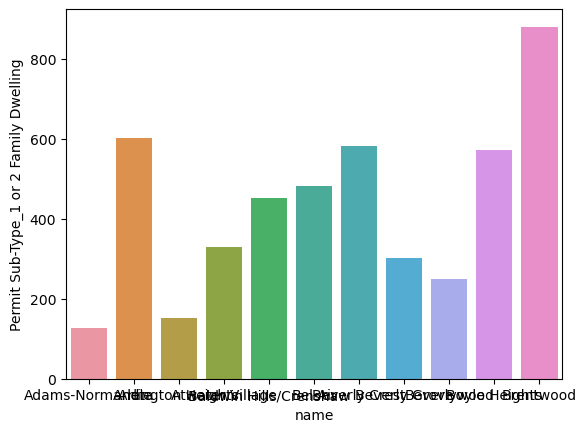

In [72]:
sns.barplot(neighborhoods_permits1.loc[:10], x="name",y='Permit Sub-Type_1 or 2 Family Dwelling')

In [62]:
neighborhoods_permits1['total_devs'] = neighborhoods_permits1['Permit Sub-Type_1 or 2 Family Dwelling'] + neighborhoods_permits1['Permit Sub-Type_Apartment'] + neighborhoods_permits1['Permit Sub-Type_Commercial']

In [ ]:
pd.set_option('display.max_rows', 500)

In [ ]:
# import rent burden csv file
df_rent_burden = pd.read_csv('data/rent_burden_ct_1.csv', dtype = {'Geo_FIPS':str})
# fips column does not have a leading zero, let's add that here
df_rent_burden['Geo_FIPS'] = df_rent_burden['Geo_FIPS'].str.zfill(11)
# inspect rent burden data frame
df_rent_burden.head()

,Geo_FIPS,total_housing_units,white_alone,black_alone,american_indian_alone,asian_alone,native_hawaiian_alone,other,two_or_more,white_alone_not_hisp,hispanic,total_pop,rent_burden
0,06037101110,644,438,0,0,58,0,52,96,372,207,3879,0.549689
1,06037101122,344,287,0,0,0,0,33,24,287,33,4247,0.706395
2,06037101220,762,450,8,16,48,0,110,130,394,285,3583,0.535433
3,06037101221,1140,815,68,0,25,0,178,54,747,269,3723,0.663158
4,06037101222,816,715,17,0,28,17,28,11,515,239,2690,0.651961


In [ ]:
tracts=gpd.read_file('data/Census_Tracts_2020.geojson')
# create FIPS column
tracts['fips'] ='06' + '037' + tracts['CT20']
tracts = tracts[['geometry','fips']]
# rename column
df_rent_burden = df_rent_burden.rename({'Geo_FIPS': 'fips'}, axis=1)
# create a new dataframe based on the join
df_tracts=tracts.merge(df_rent_burden,on="fips")
df_tracts

,geometry,fips,total_housing_units,white_alone,black_alone,american_indian_alone,asian_alone,native_hawaiian_alone,other,two_or_more,white_alone_not_hisp,hispanic,total_pop,rent_burden
0,"POLYGON ((-118.28491 34.25948, -118.28492 34.2...",06037101110,644,438,0,0,58,0,52,96,372,207,3879,0.549689
1,"POLYGON ((-118.29015 34.27417, -118.29015 34.2...",06037101122,344,287,0,0,0,0,33,24,287,33,4247,0.706395
2,"POLYGON ((-118.28100 34.25592, -118.28198 34.2...",06037101220,762,450,8,16,48,0,110,130,394,285,3583,0.535433
3,"POLYGON ((-118.28735 34.25591, -118.28863 34.2...",06037101221,1140,815,68,0,25,0,178,54,747,269,3723,0.663158
4,"POLYGON ((-118.28594 34.25405, -118.28594 34.2...",06037101222,816,715,17,0,28,17,28,11,515,239,2690,0.651961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2490,"POLYGON ((-117.98268 34.04469, -117.98287 34.0...",06037980035,110,39,0,0,6,0,65,0,23,81,629,0.354545
2491,"POLYGON ((-118.07027 34.05725, -118.07073 34.0...",06037980036,55,0,16,0,0,0,39,0,0,55,515,0.709091
2492,"POLYGON ((-118.28411 33.80773, -118.28447 33.8...",06037980037,0,0,0,0,0,0,0,0,0,0,0,0.000000
2493,"POLYGON ((-118.36674 34.01539, -118.36673 34.0...",06037980038,0,0,0,0,0,0,0,0,0,0,0,0.000000


#### Rent Burden

In [ ]:
def categorise_race_tracts(row):  
    if row['black_alone'] > row['white_alone'] and row['black_alone'] > row['hispanic'] and row['black_alone'] > row['other'] and row['black_alone'] > row['asian_alone']:
        return 'Black'
    elif row['hispanic'] > row['white_alone'] and row['hispanic'] > row['black_alone'] and row['hispanic'] > row['other'] and row['hispanic'] > row['asian_alone']:
        return 'Hispanic'
    elif row['white_alone'] > row['hispanic'] and row['white_alone'] > row['black_alone'] and row['white_alone'] > row['other'] and row['white_alone'] > row['asian_alone']:
        return 'White'
    elif row['asian_alone'] > row['hispanic'] and row['asian_alone'] > row['black_alone'] and row['asian_alone'] > row['other'] and row['black_alone'] > row['white_alone']:
        return 'Asian'
    return 'Other'

# iterate on dataframe and create new column by applying created race function
df_rent_burden['majority_race'] = df_rent_burden.apply(lambda row: categorise_race_tracts(row), axis=1)
# assess results
df_rent_burden.value_counts('majority_race')

majority_race
Hispanic    1145
White       1008
Other        212
Black        119
Asian         14
dtype: int64

Rent burden is defined broadly by the percentage of renter-occupied households who pay 30% or more of household income toward rent. This indicator will help inform the degree to which particular households are able to absorb forces of gentrification and which are susceptible. Minor cleaning was done prior to bringing in this data.

In [ ]:
# import rent burden csv file
df_rent_burden = pd.read_csv('data/rent_burden_ct_1.csv', dtype = {'Geo_FIPS':str})
# fips column does not have a leading zero, let's add that here
df_rent_burden['Geo_FIPS'] = df_rent_burden['Geo_FIPS'].str.zfill(11)
# inspect rent burden data frame
df_rent_burden.head()

,Geo_FIPS,total_housing_units,white_alone,black_alone,american_indian_alone,asian_alone,native_hawaiian_alone,other,two_or_more,white_alone_not_hisp,hispanic,total_pop,rent_burden
0,06037101110,644,438,0,0,58,0,52,96,372,207,3879,0.549689
1,06037101122,344,287,0,0,0,0,33,24,287,33,4247,0.706395
2,06037101220,762,450,8,16,48,0,110,130,394,285,3583,0.535433
3,06037101221,1140,815,68,0,25,0,178,54,747,269,3723,0.663158
4,06037101222,816,715,17,0,28,17,28,11,515,239,2690,0.651961


In [ ]:
df_rent_burden_white = df_rent_burden[df_rent_burden.majority_race == 'White']
df_rent_burden_black = df_rent_burden[df_rent_burden.majority_race == 'Black']
df_rent_burden_hispanic = df_rent_burden[df_rent_burden.majority_race == 'Hispanic']

Text(0.27, 1410, 'Correlation Coefficient: .26')

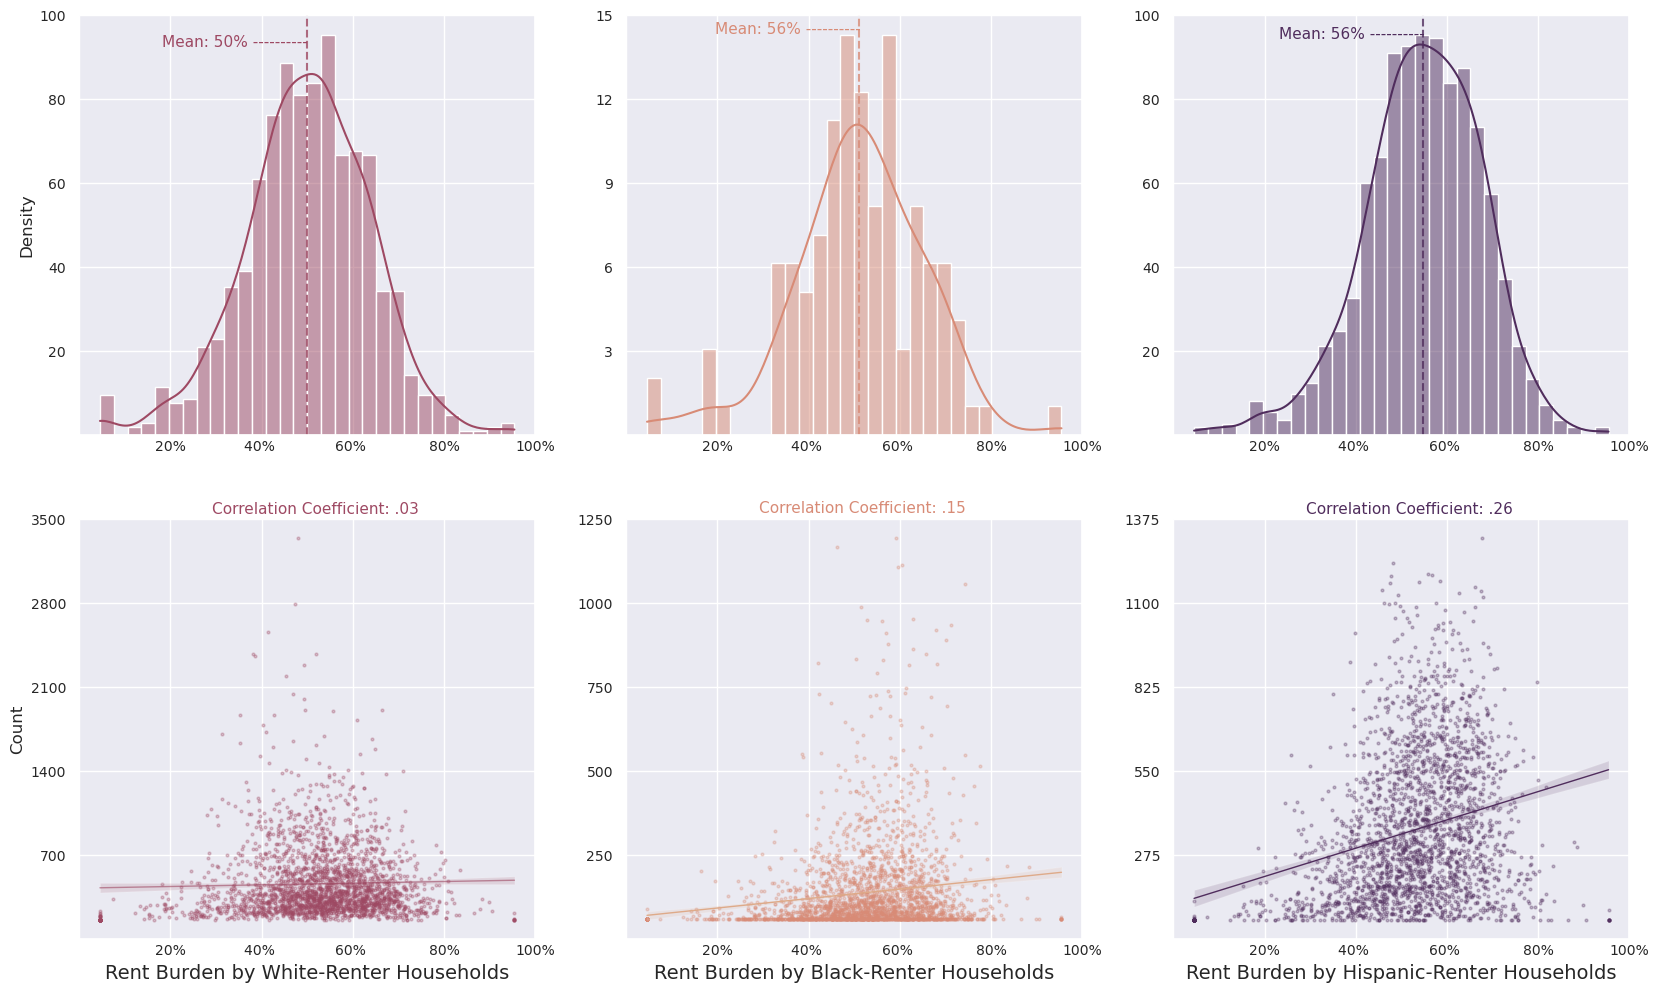

In [ ]:
#lets take a look at the correlation between the race of renter-occupied households and the percentages of rent burden for the census tract

# set subplots
fig, axes = plt.subplots(2, 3, figsize = (20, 12))

# set visual style
sns.set(style="darkgrid")

# create histogram plots
histplot_white = sns.histplot(ax = axes[0,0], data=df_rent_burden_white, x='rent_burden', alpha = .5, bins =30, color = [158/255,73/255,99/255], kde = True)
histplot_black = sns.histplot(ax = axes[0,1], data=df_rent_burden_black, x='rent_burden', alpha = .5, bins =30, color = [216/255,139/255,118/255],kde = True)
histplot_hispanic = sns.histplot(ax = axes[0,2], data=df_rent_burden_hispanic, x='rent_burden', alpha = .5, bins =30, color = [80/255,45/255,93/255], kde = True)

# create regression plots
scatter_white = sns.regplot(ax = axes[1,0], data=df_rent_burden, x= 'rent_burden', y= 'white_alone', scatter_kws={"color": [158/255,73/255,99/255], "s": 4, "alpha" : .3 }, line_kws={'linewidth':1,'alpha':.6, "color": [158/255,73/255,99/255]})
scatter_black = sns.regplot(ax = axes[1,1], data=df_rent_burden, x= 'rent_burden', y= 'black_alone', scatter_kws={"color": [216/255,139/255,118/255], "s": 4, "alpha" : .3}, line_kws={'linewidth':1,'alpha':1, "color": [222/255,170/255,137/255]})
scatter_hispanic = sns.regplot(ax = axes[1,2], data=df_rent_burden, x= 'rent_burden', y= 'hispanic', scatter_kws={"color": [80/255,45/255,93/255], "s": 4, "alpha" : .3}, line_kws={'linewidth':1,'alpha':1, "color": [80/255,45/255,93/255]})

# change x-axis and y-axis labels
axes[1,0].set_xlabel('Rent Burden by White-Renter Households', fontsize = 14)
axes[1,1].set_xlabel('Rent Burden by Black-Renter Households', fontsize = 14)
axes[1,2].set_xlabel('Rent Burden by Hispanic-Renter Households', fontsize = 14)

axes[1,0].set_ylabel('Count')
axes[1,1].set_ylabel(' ')
axes[1,2].set_ylabel(' ')

axes[0,0].set(xlabel=' ', ylabel = 'Density')
axes[0,1].set(xlabel=' ', ylabel = ' ')
axes[0,2].set(xlabel=' ', ylabel = ' ')

#align x-axis and y-axis grid lines for histogram plots
histplot_white.xaxis.set_major_locator(LinearLocator(6))
histplot_black.xaxis.set_major_locator(LinearLocator(6)) 
histplot_hispanic.xaxis.set_major_locator(LinearLocator(6)) 
histplot_white.yaxis.set_major_locator(LinearLocator(6))
histplot_black.yaxis.set_major_locator(LinearLocator(6)) 
histplot_hispanic.yaxis.set_major_locator(LinearLocator(6))

#align x-axis and y-axis grid lines for scatter plots
scatter_white.xaxis.set_major_locator(LinearLocator(6))
scatter_black.xaxis.set_major_locator(LinearLocator(6)) 
scatter_hispanic.xaxis.set_major_locator(LinearLocator(6)) 
scatter_white.yaxis.set_major_locator(LinearLocator(6))
scatter_black.yaxis.set_major_locator(LinearLocator(6)) 
scatter_hispanic.yaxis.set_major_locator(LinearLocator(6))

# change x-axis and y-axis tick labels for histogram plots
histplot_white.set_xticklabels(labels = [' ', '20%', '40% ', '60% ', '80%', '100%'], fontsize = 10, y=.02)
histplot_black.set_xticklabels(labels = [' ', '20%', '40% ', '60% ', '80%', '100%'], fontsize = 10, y=.02)
histplot_hispanic.set_xticklabels(labels = [' ', '20%', '40% ', '60% ', '80%', '100%'], fontsize = 10, y=.02)
scatter_white.set_xticklabels(labels = [' ', '20%', '40% ', '60% ', '80%', '100%'], fontsize = 10, y=.02)
scatter_black.set_xticklabels(labels = [' ', '20%', '40% ', '60% ', '80%', '100%'], fontsize = 10, y=.02)
scatter_hispanic.set_xticklabels(labels = [' ', '20%', '40% ', '60% ', '80%', '100%'], fontsize = 10, y=.02)

histplot_white.set_yticklabels(labels = [' ', '20', '40', '60', '80', '100'], fontsize = 10, y=.02)
histplot_black.set_yticklabels(labels = [' ', '3', '6', '9', '12', '15'], fontsize = 10, y=.02)
histplot_hispanic.set_yticklabels(labels = [' ', '20', '40', '60', '80', '100'], fontsize = 10, y=.02)
scatter_white.set_yticklabels(labels = [' ', '700', '1400', '2100', '2800', '3500'], fontsize = 10, y=.02)
scatter_black.set_yticklabels(labels = [' ', '250', '500', '750', '1000', '1250'], fontsize = 10, y=.02)
scatter_hispanic.set_yticklabels(labels = [' ', '275', '550', '825', '1100', '1375'], fontsize = 10, y=.02)

# add mean vertical line and text for histogram plots
histplot_white.axvline(x = df_rent_burden_white.rent_burden.mean(), linewidth = 2, alpha = .8, ls = '--', lw = 1.5, color = [158/255,73/255,99/255])
histplot_white.text(x = df_rent_burden_white.rent_burden.mean() - .35,
        y = 97, 
        s = 'Mean: 50% ---------- ', 
        color = [158/255,73/255,99/255],
        weight = 'normal', 
        fontsize = 11)


histplot_black.axvline(x = df_rent_burden_black.rent_burden.mean(), linewidth = 2, alpha = .8, ls = '--', lw = 1.5, color = [216/255,139/255,118/255])
histplot_black.text(x = df_rent_burden_black.rent_burden.mean() - .31,
        y = 14.05, 
        s = 'Mean: 56% ---------- ', 
        color = [216/255,139/255,118/255],
        weight = 'normal', 
        fontsize = 11)

histplot_hispanic.axvline(x = df_rent_burden_hispanic.rent_burden.mean(), linewidth = 2, alpha = .8, ls = '--', lw = 1.5, color = [80/255,45/255,93/255])
histplot_hispanic.text(x = df_rent_burden_hispanic.rent_burden.mean() - .28,
        y = 107, 
        s = 'Mean: 56% ---------- ', 
        color = [80/255,45/255,93/255],
        weight = 'normal', 
        fontsize = 11)

# add correlation coefficent values
scatter_white.text(x = .27,
        y = 3700, 
        s = 'Correlation Coefficient: .03', 
        color = [158/255,73/255,99/255],
        weight = 'normal', 
        fontsize = 11)

scatter_black.text(x = .27,
        y = 1300, 
        s = 'Correlation Coefficient: .15', 
        color = [216/255,139/255,118/255],
        weight = 'normal', 
        fontsize = 11)

scatter_hispanic.text(x = .27,
        y = 1410, 
        s = 'Correlation Coefficient: .26', 
        color = [80/255,45/255,93/255],
        weight = 'normal', 
        fontsize = 11)

#### Rent Price Shifts

In [ ]:
df_rent_2017 = pd.read_csv('data/rent_2017.csv')
df_rent_2020 = pd.read_csv('data/rent_2020.csv', dtype = {'tract':str})
df_rent_2021 = pd.read_csv('data/rent_2021.csv', dtype = {'tract':str})

In [ ]:
df_rent_combined=df_rent_2021.merge(df_rent_2017,on="Geo_FIPS")

In [ ]:
df_rent_2020 = pd.read_csv('data/rent_2020.csv', dtype = {'tract':str})
df_rent_combined_1=df_rent_2021.merge(df_rent_2020,on="Geo_FIPS")
df_rent_combined_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2498 entries, 0 to 2497
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Geo_FIPS   2498 non-null   int64  
 1   tract      2498 non-null   object 
 2   rent_2021  2429 non-null   float64
 3   rent_2020  2427 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 97.6+ KB


In [ ]:
tracts=gpd.read_file('data/Census_Tracts_2020.geojson')
tracts = tracts[['CT20','geometry']]
tracts = tracts.rename(columns={"CT20": "tract"})
tracts.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2495 entries, 0 to 2494
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   tract     2495 non-null   object  
 1   geometry  2495 non-null   geometry
dtypes: geometry(1), object(1)
memory usage: 39.1+ KB


In [ ]:
dfr=df_rent_combined_1.merge(tracts,on="tract")
dfr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2495 entries, 0 to 2494
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Geo_FIPS   2495 non-null   int64   
 1   tract      2495 non-null   object  
 2   rent_2021  2429 non-null   float64 
 3   rent_2020  2427 non-null   float64 
 4   geometry   2495 non-null   geometry
dtypes: float64(2), geometry(1), int64(1), object(1)
memory usage: 117.0+ KB


In [ ]:
dfr['rent_perc_change'] = dfr.rent_2021/dfr.rent_2020

In [ ]:
gdfr = dfr.set_geometry('geometry')